In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ==================== Seed Setting ====================
def set_seed(seed=1443):
    """Set seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    cudnn.benchmark = False
    cudnn.deterministic = True


# ==================== Dataset Class ====================
class CustomDataset(Dataset):
    """Custom Dataset for loading CSV data"""

    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# ==================== Neural Network Model ====================
class MultiClassNN(nn.Module):
    """
    Neural Network Architecture:
    - Input: 2 neurons
    - Hidden Layer 1: 4 neurons + ReLU
    - Hidden Layer 2: 4 neurons + ReLU
    - Output: 3 neurons + Softmax (handled by CrossEntropyLoss)
    """

    def __init__(self):
        super(MultiClassNN, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(2, 4)  # W1: R^(2x4)
        self.fc2 = nn.Linear(4, 4)  # W2: R^(4x4)
        self.fc3 = nn.Linear(4, 3)  # W3: R^(4x3)
        self.relu = nn.ReLU()

        # Initialize weights with Kaiming Uniform
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Kaiming Uniform initialization"""
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity="relu")
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity="relu")
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity="relu")

        # Initialize biases to zero
        if self.fc1.bias is not None:
            nn.init.zeros_(self.fc1.bias)
        if self.fc2.bias is not None:
            nn.init.zeros_(self.fc2.bias)
        if self.fc3.bias is not None:
            nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        """Forward pass through the network"""
        x = self.relu(self.fc1(x))  # Hidden layer 1
        x = self.relu(self.fc2(x))  # Hidden layer 2
        x = self.fc3(x)  # Output layer (logits)
        return x


# ==================== Training Function ====================
def train_model(model, train_loader, criterion, optimizer, device, epochs=100):
    """
    Train the neural network

    Returns:
        loss_history: List of average training losses per epoch
    """
    model.train()
    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        for batch_features, batch_labels in train_loader:
            # Move data to device
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_features)

            # Compute loss
            loss = criterion(outputs, batch_labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        # Calculate average loss for the epoch
        avg_loss = epoch_loss / num_batches
        loss_history.append(avg_loss)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

    return loss_history


# ==================== Testing Function ====================
def test_model(model, test_loader, device):
    """
    Test the neural network and compute accuracy

    Returns:
        accuracy: Testing accuracy (%)
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_features)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)

            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


# ==================== Data Loading Function ====================
def load_data(train_path="train_q4.csv", test_path="test_q4.csv"):
    """
    Load training and testing data from CSV files
    Assumes: First columns are features, last column is label
    """
    # Load CSV files
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # Separate features and labels
    # Assuming last column is label, rest are features
    X_train = train_df.iloc[:, :-1].values
    y_train = train_df.iloc[:, -1].values

    X_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values

    # If labels are not 0-indexed, convert them
    unique_labels = np.unique(np.concatenate([y_train, y_test]))
    if not np.array_equal(unique_labels, np.arange(len(unique_labels))):
        label_mapping = {label: idx for idx, label in enumerate(sorted(unique_labels))}
        y_train = np.array([label_mapping[label] for label in y_train])
        y_test = np.array([label_mapping[label] for label in y_test])

    return X_train, y_train, X_test, y_test


# ==================== Main Execution ====================
def main():
    # Configuration
    seed = 1443
    batch_size = 256
    epochs = 100
    learning_rates = [0.4, 0.1, 0.001]

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load data
    print("\nLoading data...")
    X_train, y_train, X_test, y_test = load_data("train_q4.csv", "test_q4.csv")
    print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
    print(
        f"Feature dimension: {X_train.shape[1]}, Number of classes: {len(np.unique(y_train))}"
    )

    # Create datasets
    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Store results for each learning rate
    results = {}

    # Train with different learning rates
    for lr in learning_rates:
        print(f"\n{'=' * 60}")
        print(f"Training with Learning Rate: {lr}")
        print(f"{'=' * 60}")

        # Set seed for reproducibility
        set_seed(seed)

        # Initialize model
        model = MultiClassNN().to(device)

        # Initialize optimizer
        optimizer = optim.SGD(model.parameters(), lr=lr)

        # Train model
        loss_history = train_model(
            model, train_loader, criterion, optimizer, device, epochs
        )

        # Test model
        accuracy = test_model(model, test_loader, device)

        # Store results
        results[lr] = {
            "loss_history": loss_history,
            "accuracy": accuracy,
            "model": model,
        }

        print(f"\nTest Accuracy with LR={lr}: {accuracy:.2f}%")

    # ==================== Visualization ====================
    print(f"\n{'=' * 60}")
    print("Generating Plots...")
    print(f"{'=' * 60}")

    # Plot training loss curves
    plt.figure(figsize=(12, 5))

    # Subplot 1: Training Loss Curves
    plt.subplot(1, 2, 1)
    for lr in learning_rates:
        plt.plot(
            range(1, epochs + 1),
            results[lr]["loss_history"],
            label=f"LR={lr}",
            linewidth=2,
        )
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Training Loss", fontsize=12)
    plt.title("Training Loss vs Epoch", fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Test Accuracy Comparison
    plt.subplot(1, 2, 2)
    accuracies = [results[lr]["accuracy"] for lr in learning_rates]
    bars = plt.bar(
        [str(lr) for lr in learning_rates],
        accuracies,
        color=["#FF6B6B", "#4ECDC4", "#45B7D1"],
        alpha=0.8,
    )
    plt.xlabel("Learning Rate", fontsize=12)
    plt.ylabel("Test Accuracy (%)", fontsize=12)
    plt.title("Test Accuracy Comparison", fontsize=14, fontweight="bold")
    plt.ylim([0, 100])

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.2f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()
    plt.savefig("training_results.png", dpi=300, bbox_inches="tight")
    plt.show()

    # ==================== Summary Report ====================
    print(f"\n{'=' * 60}")
    print("SUMMARY REPORT")
    print(f"{'=' * 60}")
    print(f"{'Learning Rate':<20} {'Test Accuracy':<20} {'Final Loss':<20}")
    print(f"{'-' * 60}")
    for lr in learning_rates:
        final_loss = results[lr]["loss_history"][-1]
        accuracy = results[lr]["accuracy"]
        print(f"{lr:<20} {accuracy:<20.2f}% {final_loss:<20.4f}")

    # ==================== Analysis ====================
    print(f"\n{'=' * 60}")
    print("FINDINGS AND ANALYSIS")
    print(f"{'=' * 60}")

    best_lr = max(learning_rates, key=lambda lr: results[lr]["accuracy"])
    best_accuracy = results[best_lr]["accuracy"]

    print(f"\n1. Best Learning Rate: {best_lr} (Accuracy: {best_accuracy:.2f}%)")

    print("\n2. Learning Rate Analysis:")
    for lr in learning_rates:
        loss_history = results[lr]["loss_history"]
        accuracy = results[lr]["accuracy"]

        if lr == 0.4:
            print(f"\n   LR = {lr}:")
            if loss_history[0] > loss_history[-1] * 2:
                print(f"   - High learning rate leads to fast initial convergence")
            if accuracy < 50:
                print(f"   - May cause instability or overshooting optimal weights")
            else:
                print(f"   - Achieves reasonable performance with fast convergence")

        elif lr == 0.1:
            print(f"\n   LR = {lr}:")
            print(f"   - Moderate learning rate provides balanced convergence")
            if accuracy == best_accuracy:
                print(f"   - Optimal balance between convergence speed and stability")

        elif lr == 0.001:
            print(f"\n   LR = {lr}:")
            loss_decrease = loss_history[0] - loss_history[-1]
            if loss_decrease < 0.5:
                print(f"   - Very slow convergence, may need more epochs")
            if accuracy < best_accuracy - 5:
                print(f"   - Underfitting due to insufficient learning")

    print("\n3. Convergence Behavior:")
    for lr in learning_rates:
        loss_history = results[lr]["loss_history"]
        # Check if loss is still decreasing at the end
        last_10_epochs = loss_history[-10:]
        if last_10_epochs[0] - last_10_epochs[-1] > 0.01:
            print(f"   - LR={lr}: Still converging, could benefit from more epochs")
        else:
            print(f"   - LR={lr}: Converged or plateaued")

    print(f"\n{'=' * 60}\n")


Using device: cuda

Loading data...
Training samples: 8000, Testing samples: 2000
Feature dimension: 2, Number of classes: 3

Training with Learning Rate: 0.4
Epoch [10/100], Loss: 0.1749
Epoch [20/100], Loss: 0.1913
Epoch [30/100], Loss: 1.0012
Epoch [40/100], Loss: 0.6718
Epoch [50/100], Loss: 0.6688
Epoch [60/100], Loss: 0.6681
Epoch [70/100], Loss: 0.6712
Epoch [80/100], Loss: 0.6687
Epoch [90/100], Loss: 0.6664
Epoch [100/100], Loss: 0.6660

Test Accuracy with LR=0.4: 57.50%

Training with Learning Rate: 0.1
Epoch [10/100], Loss: 0.1293
Epoch [20/100], Loss: 0.0912
Epoch [30/100], Loss: 0.0754
Epoch [40/100], Loss: 0.0648
Epoch [50/100], Loss: 0.0563
Epoch [60/100], Loss: 0.0515
Epoch [70/100], Loss: 0.0501
Epoch [80/100], Loss: 0.0449
Epoch [90/100], Loss: 0.0458
Epoch [100/100], Loss: 0.0410

Test Accuracy with LR=0.1: 95.15%

Training with Learning Rate: 0.001
Epoch [10/100], Loss: 1.5934
Epoch [20/100], Loss: 0.9401
Epoch [30/100], Loss: 0.7938
Epoch [40/100], Loss: 0.7518
Epo

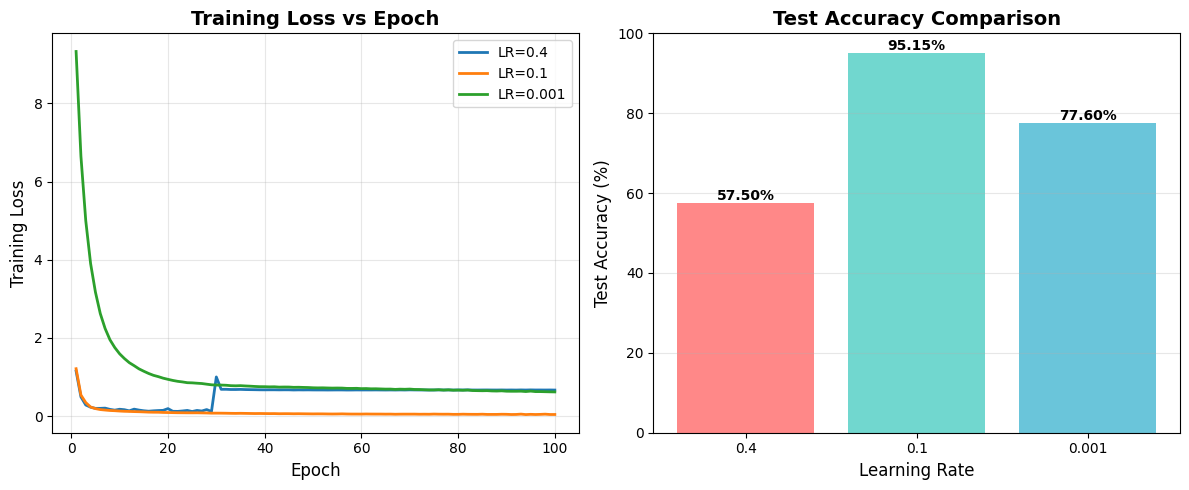


SUMMARY REPORT
Learning Rate        Test Accuracy        Final Loss          
------------------------------------------------------------
0.4                  57.50               % 0.6660              
0.1                  95.15               % 0.0410              
0.001                77.60               % 0.6183              

FINDINGS AND ANALYSIS

1. Best Learning Rate: 0.1 (Accuracy: 95.15%)

2. Learning Rate Analysis:

   LR = 0.4:
   - Achieves reasonable performance with fast convergence

   LR = 0.1:
   - Moderate learning rate provides balanced convergence
   - Optimal balance between convergence speed and stability

   LR = 0.001:
   - Underfitting due to insufficient learning

3. Convergence Behavior:
   - LR=0.4: Converged or plateaued
   - LR=0.1: Converged or plateaued
   - LR=0.001: Still converging, could benefit from more epochs




In [2]:
main()